# YOLOv3 - Tensorflow 2.0

## Import all necessary libraries

In [1]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, Input, Lambda,
    LeakyReLU, UpSampling2D, 
    MaxPool2D, 
    concatenate, Add, ZeroPadding2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

%matplotlib inline

print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


## GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


## Load Data
    
- [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/)

    - JPEGImages: 存放訓練和測試圖面
    - Annatations: XML格式的標籤檔案，每個XML檔案都對應於Image資料夾的一張圖片

### Load the tf.data.Dataset from TFRecord files

In [3]:
# load data from local
#raw_train_dataset = tf.data.TFRecordDataset('./data/train_voc.tfrecord')

raw_train_dataset = tf.data.TFRecordDataset('./data/voc2012_train.tfrecord')
raw_val_dataset = tf.data.TFRecordDataset('./data/voc2012_val.tfrecord')
raw_train_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

## Explore the dataset

### 1. Parse VOC dataset

In [4]:
for raw_train_data in raw_train_dataset.take(1):    
    example = tf.train.Example()
    example.ParseFromString(raw_train_data.numpy())  
    #print(example)

In [5]:
# Create a dictionary describing the features.
image_feature_description = {
    'filename': tf.io.FixedLenFeature([], tf.string),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'classes': tf.io.VarLenFeature(tf.int64),
    'x_mins': tf.io.VarLenFeature(tf.float32),
    'y_mins': tf.io.VarLenFeature(tf.float32),
    'x_maxes': tf.io.VarLenFeature(tf.float32),
    'y_maxes': tf.io.VarLenFeature(tf.float32),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def parse_tf_example(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.io.parse_single_example(example_proto, image_feature_description)
    
    x_train = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)
    #x_train = tf.image.resize(x_train, (416, 416)) # yolov3 - input size
    #x_train /= 255.
    
    width = tf.cast(parsed_example['width'], tf.float32)
    height = tf.cast(parsed_example['height'], tf.float32)
    
    labels = tf.sparse.to_dense(parsed_example['classes'])
    labels = tf.cast(labels, tf.float32)
    
    xmin = tf.sparse.to_dense(parsed_example['x_mins'])
    ymin = tf.sparse.to_dense(parsed_example['y_mins'])
    xmax = tf.sparse.to_dense(parsed_example['x_maxes'])
    ymax = tf.sparse.to_dense(parsed_example['y_maxes'])
    
    y_train = tf.stack([xmin,ymin,
                        xmax,ymax,
                        labels], axis=1)
    
    return x_train, y_train

train_dataset = raw_train_dataset.map(parse_tf_example)
val_dataset = raw_val_dataset.map(parse_tf_example)
train_dataset

<MapDataset shapes: ((None, None, 3), (None, 5)), types: (tf.uint8, tf.float32)>

### 2. Show the data

- (xmin, ymin, xmax, ymax): already normalization to 0~1.

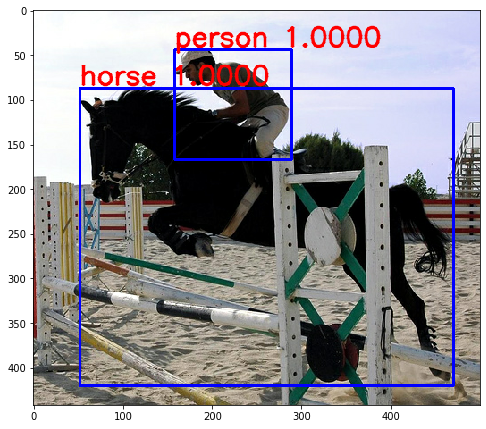

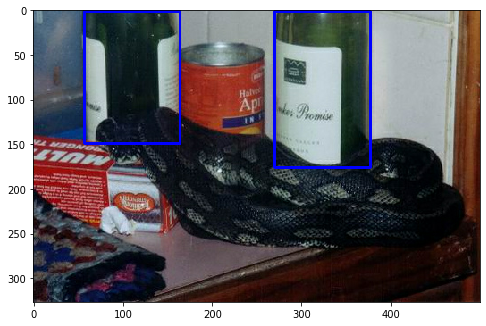

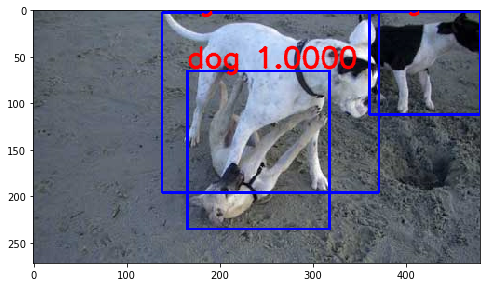

In [6]:
class_names = [c.strip() for c in open('./model_data/voc2012_classes.txt').readlines()]
font_face = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_thickness = 2

for i, (x, y) in enumerate(train_dataset.take(3)):
    img = x.numpy()
    height, width = tf.shape(img)[0].numpy(), tf.shape(img)[1].numpy()
    
    for xmin, ymin, xmax, ymax, label in y.numpy():
        left = (xmin * width).astype('int32')
        top = (ymin * height).astype('int32')
        right = (xmax * width).astype('int32')
        bottom = (ymax * height).astype('int32')
        label = class_names[int(label)]
    
        # cv2.rectangle(image, (left, top), (right, bottom), color, thickness)
        cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 2)
        cv2.putText(img, '{} {:.4f}'.format(label, 1.0000), (left, int(top - 4)), 
                    font_face, font_scale, (255, 0, 0), font_thickness, cv2.LINE_AA)
    
    f, (ax1) = plt.subplots(1, 1, figsize=(8,8))
    f.subplots_adjust(hspace = .2, wspace = .05)
    
    ax1.imshow(img)    

## YOLOv3 Model's setting and parameter. 

In [7]:
# anchor boxes
YOLO_ANCHORS = np.array(
    [(10, 13), (16, 30), (33, 23), 
     (30, 61), (62, 45), (59, 119),
     (116, 90), (156, 198), (373, 326)], np.float32) / 416

YOLO_ANCHORS_MASKS = np.array([[6, 7, 8],
                               [3, 4, 5],
                               [0, 1, 2]])

num_max_box = 100

## Preprocess the dataset

- images: resize to (416, 416)
- labels: `(xmin, ymi, xmax, ymax, class)` -> `(grid, grid, (bx, by, bw, bh, class))`

- max ture boxes: 100

In [8]:
@tf.function
def transform_bboxes_for_output(y_true, grid_size, anchor_idxs, best_anchor_idx):
    # y_true: (max_boxes, [x, y, w, h, classes])
    N = tf.shape(y_true)[0]
  
    # y_true_out: (grid, grid, anchors, [x, y, w, h, obj, class])
    y_true_out = tf.zeros(
        (grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))
    
    anchor_idxs = tf.cast(anchor_idxs, tf.int32)
    
    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    
    # Find which grid includes the center of object
    #boxes_xy = y_true[..., 0:2]
    #grid_xy = tf.cast(boxes_xy // (1 / grid_size), tf.int32)

    for i in range(N):
        if tf.equal(y_true[i][0], 0):
            continue
        
        anchor_eq = tf.equal(
            anchor_idxs, best_anchor_idx[i][0])
        
        if tf.reduce_any(anchor_eq):
            # Find which grid includes the center of object
            boxes_xy = y_true[i][0:2]
            grid_xy = tf.cast(boxes_xy // (1 / grid_size), tf.int32)
            
            anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)

            indices = indices.write(i, [grid_xy[1], grid_xy[0], anchor_idx[0][0]])
            updates = updates.write(i, [y_true[i][0], y_true[i][1], y_true[i][2], y_true[i][3], 1, y_true[i][4]])
        
    #tf.print("indices: ", indices.stack())
    #tf.print("updates: ", updates.stack())
    
    return tf.tensor_scatter_nd_update(
        y_true_out, indices.stack(), updates.stack())

In [9]:
def transform_bboxes(y_train, anchors, anchor_masks, image_size=416):
    """Area of anchor."""
    # anchors shape: (9, 2)
    # Note: normalization anchors to 0~1 (anchors / 416)
    #       -> anchors and boxes_wh are moved to origin point
    #       -> we can conveniently find the minimum 
    #          between anchors and boxes_wh to find the intersection area.
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1] # (9,)
    
    # y_train shape: (N, (x, y, w, h, classes))
    boxes_wh = y_train[..., 2:4] # (N, 2)
    
    # expand dimension for compare with anchor
    boxes_wh = tf.tile(tf.expand_dims(boxes_wh, -2),
                     (1, tf.shape(anchors)[0], 1)) # (N, 9, 2)
    boxes_area = boxes_wh[..., 0] * boxes_wh[..., 1] # (N, 9)
    
    """Find IOU between box shifted to origin and anchor box."""    
    intersection = tf.minimum(boxes_wh[..., 0], anchors[..., 0]) * \
        tf.minimum(boxes_wh[..., 1], anchors[..., 1]) # (N, 9)
    iou = intersection / (boxes_area + anchor_area - intersection) # (N, 9)
    
    """Find the best iou."""
    best_anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    best_anchor_idx = tf.expand_dims(best_anchor_idx, -1) # (N, 1)
    best_anchor_idx = tf.cast(best_anchor_idx, tf.int32)
    
    """Find which grid includes the center of object."""
    y_outs = []
    grid_size = image_size // 32

    for anchor_idxs in anchor_masks:
        y_outs.append(transform_bboxes_for_output(
            y_train, grid_size, anchor_idxs, best_anchor_idx))
        grid_size *=2

    return tuple(y_outs)

In [10]:
def preprocess_data(x_train, y_train, anchors, anchor_masks, size=416):
    """preprocess the data"""
    # Resize the image data.
    x_train = tf.image.resize(x_train, (size, size))
    x_train /= 255.
    
    # Box preprocessing.
    # Origin boxes: (xmin, ymi, xmax, ymax, classes)
    boxes = tf.reshape(y_train, [-1,5])
    boxes_xy = 0.5 * (boxes[:, 2:4] + boxes[:, 0:2])
    boxes_wh = boxes[:, 2:4] - boxes[:, 0:2]
    # New boxes: (x_center, y_center, w, h, classes)
    new_boxes = tf.concat((boxes_xy, boxes_wh, boxes[:, 4:]), axis=-1)
    
    """Add zero pad for training 
    
    paddings = [[row_top, row_bottom], [col_left, col_right]]
    """
    paddings = [[0, num_max_box - tf.shape(new_boxes)[0]], [0, 0]] 
    new_y_train = tf.pad(new_boxes, paddings)
    
    new_y_train = transform_bboxes(new_y_train, anchors, anchor_masks)
    
    return x_train, new_y_train

In [11]:
# Use deep copy()
anchors = YOLO_ANCHORS
anchor_masks = YOLO_ANCHORS_MASKS

train_dataset_2 = train_dataset.map(lambda x, y: (
    preprocess_data(x, y, anchors, anchor_masks)))
val_dataset_2 = val_dataset.map(lambda x, y: (
    preprocess_data(x, y, anchors, anchor_masks)))

train_dataset_2

<MapDataset shapes: ((416, 416, 3), ((13, 13, 3, 6), (26, 26, 3, 6), (52, 52, 3, 6))), types: (tf.float32, (tf.float32, tf.float32, tf.float32))>

### Show the result of the dataset after preprocessing.

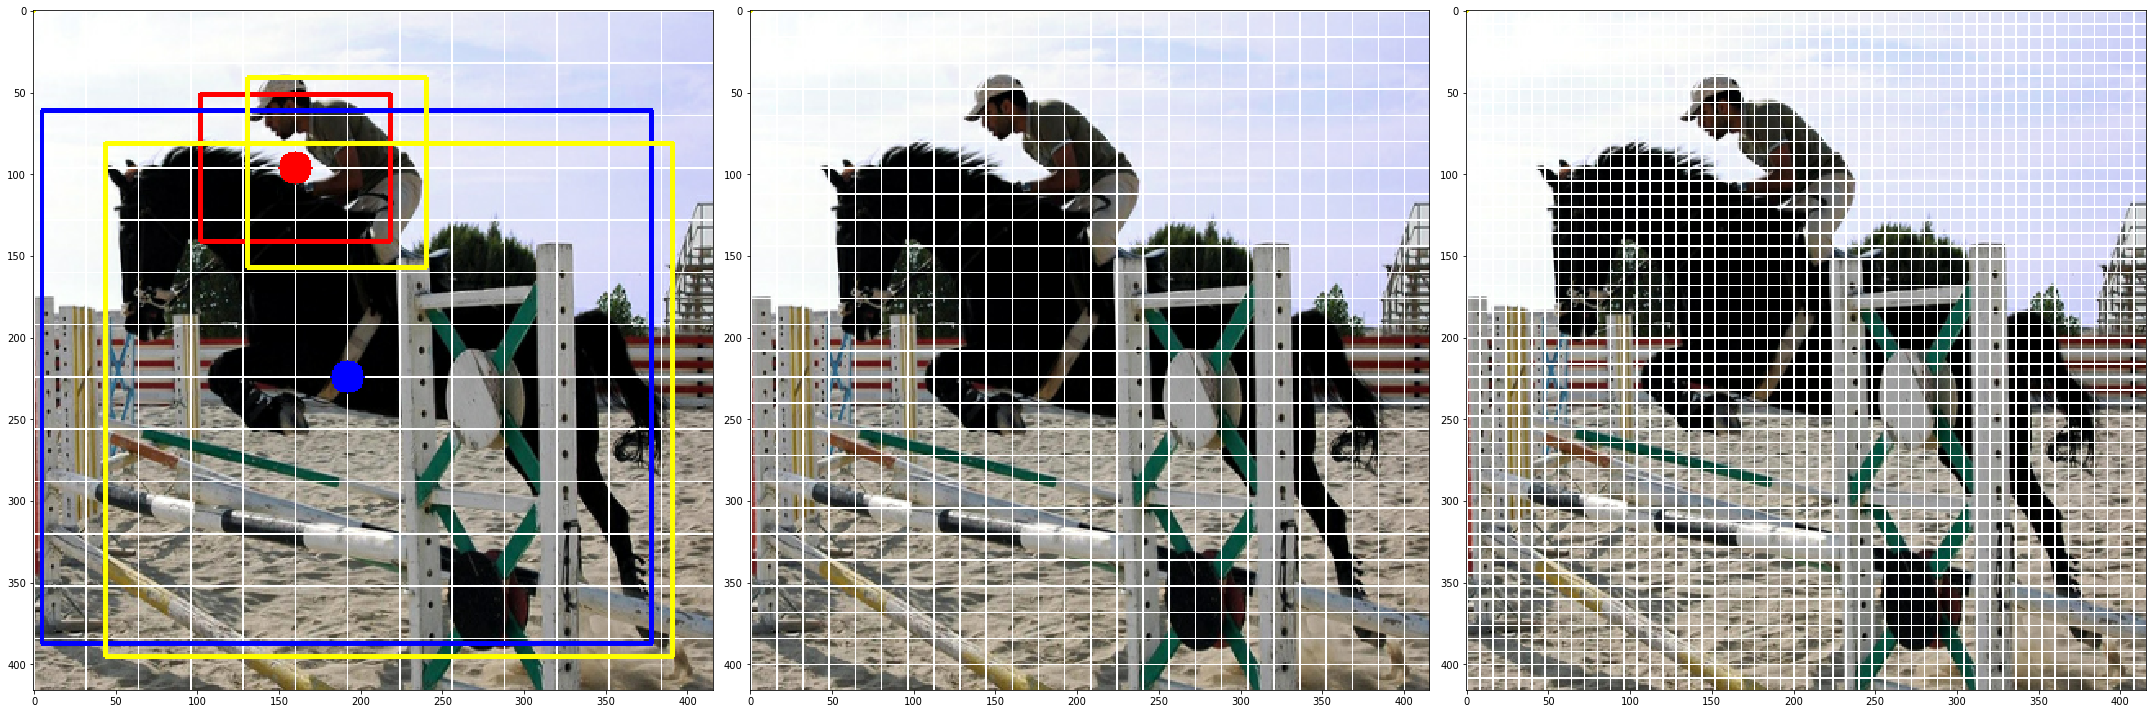

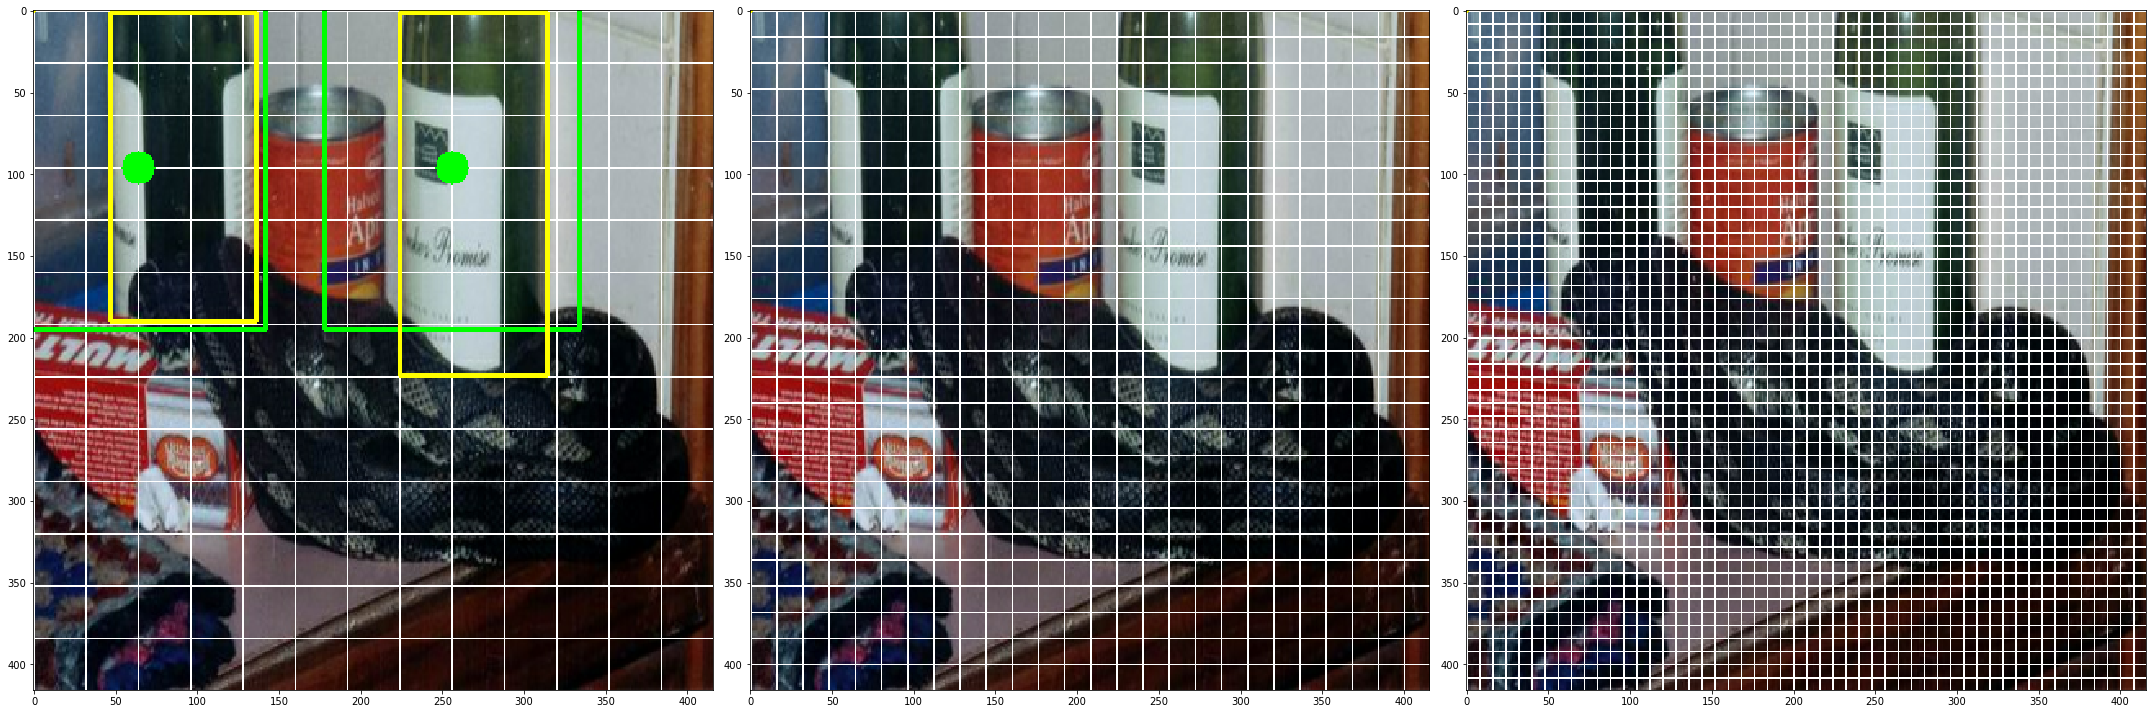

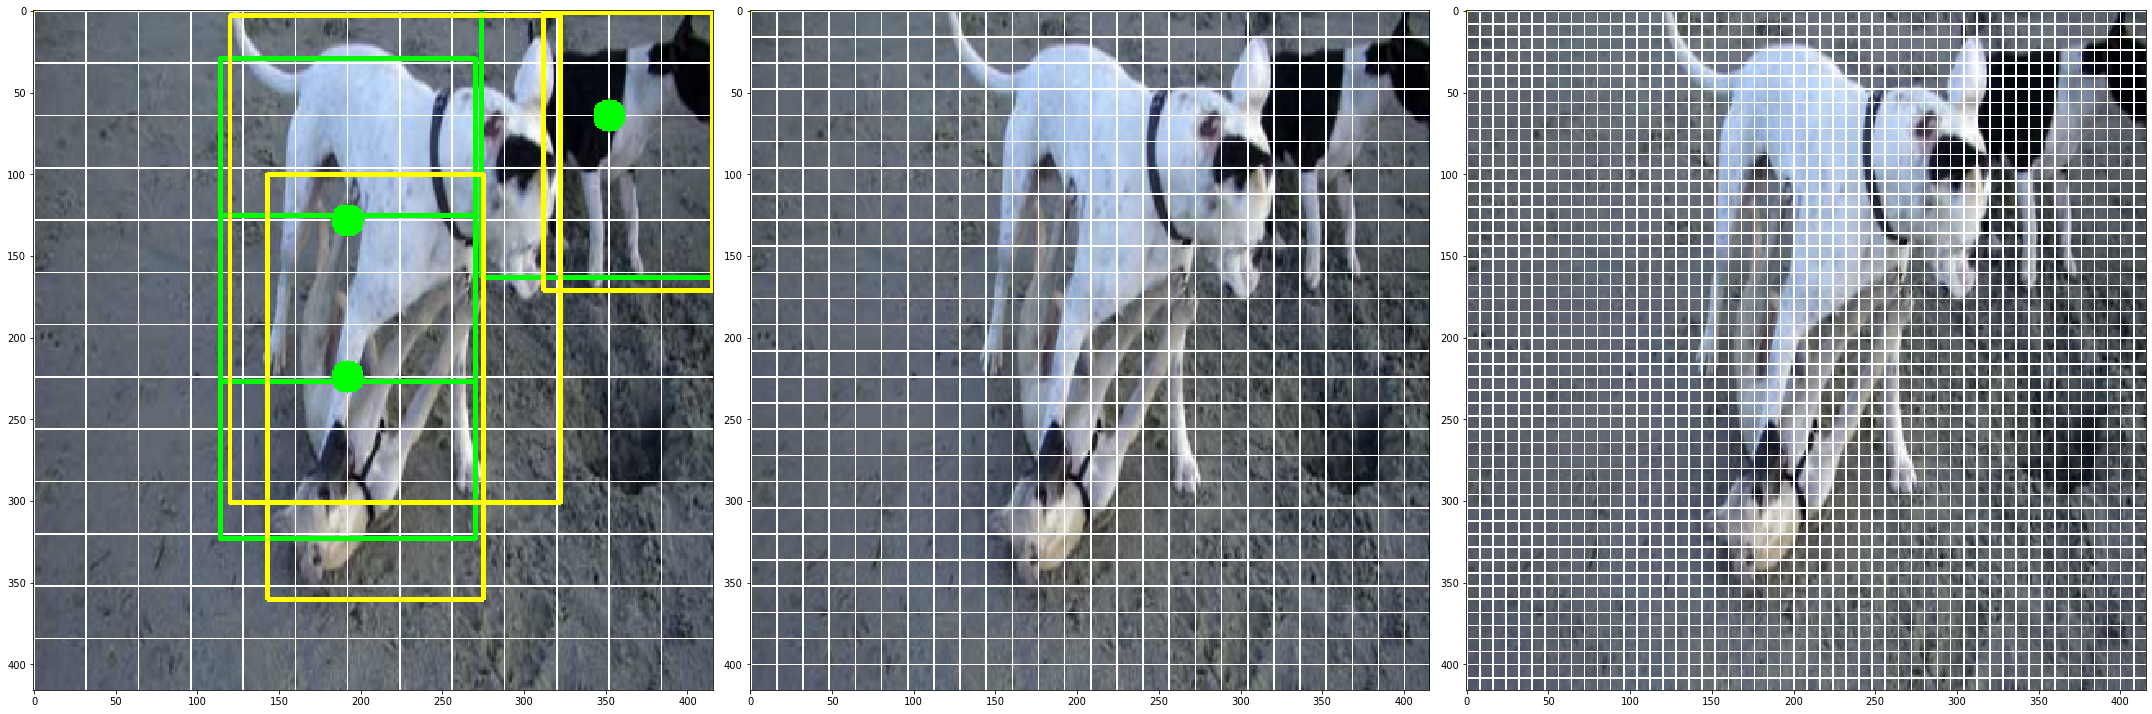

In [12]:
for x, y_outs in train_dataset_2.take(3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 30))
    f.subplots_adjust(hspace = .2, wspace = .05)
    axs = (ax1, ax2, ax3)
    
    for anchor_box_idx, y in enumerate(y_outs):
        img = x.numpy()
        img = np.array(img * 255, dtype=np.uint8)
        true_boxes = y.numpy()

        # Custom (rgb) grid color and object color
        colors = [(255,0,0), (0,255,0), (0,0,255)]
        grid_color = [255, 255, 255] # (255,255,255)

        # Plot grid box
        # Modify the image to include the grid
        dowsample_size = 32 // pow(2, anchor_box_idx)
        dx, dy = (dowsample_size, dowsample_size) # downsamples the input by 32
        img[:,::dy,:] = grid_color
        img[::dx,:,:] = grid_color

        # Plot anchor box
        anchor_exist = tf.not_equal(true_boxes[:, :, :, 0], 0)
        anchor_boxes_idx = tf.cast(tf.where(anchor_exist), tf.int32)
        for dy, dx, anchor_idx in anchor_boxes_idx:
            # 1. anchor box center
            anchor_boxes_xy = [(dx * dowsample_size, dy * dowsample_size)]
            for i, box_xy in enumerate(anchor_boxes_xy):
                cv2.circle(img, box_xy, 10, colors[anchor_idx], -1)

            # 2. anchor box
            anchor_box_wh = YOLO_ANCHORS[6 - anchor_box_idx * 3 + anchor_idx] * 416
            anchor_box_wh_half = anchor_box_wh / 2.
            bbox_mins = anchor_boxes_xy - anchor_box_wh_half
            bbox_maxes = anchor_boxes_xy + anchor_box_wh_half

            for i in range(len(bbox_mins)):
                cv2.rectangle(img, (int(bbox_mins[i][0]), int(bbox_mins[i][1])), (int(bbox_maxes[i][0]), int(bbox_maxes[i][1])), colors[anchor_idx], 2)

        # Plot true box
        true_xy = true_boxes[..., 0:2] * 416
        ture_wh = true_boxes[..., 2:4] * 416
        true_wh_half = ture_wh / 2.
        true_mins = tf.cast(true_xy - true_wh_half, tf.int32)
        true_maxes = tf.cast(true_xy + true_wh_half, tf.int32)
        true_bbox = tf.concat((true_mins, true_maxes), axis=-1)

        for grid_y in true_bbox:
            for grid_x in grid_y:
                for box in grid_x:
                    cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 2)

        axs[anchor_box_idx].imshow(img)
    f.tight_layout()

## Prepare the data for training and validation

In [13]:
train_ds = train_dataset_2.shuffle(buffer_size=512).batch(16)
train_ds = train_ds.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = val_dataset_2.batch(16)

train_ds

<PrefetchDataset shapes: ((None, 416, 416, 3), ((None, 13, 13, 3, 6), (None, 26, 26, 3, 6), (None, 52, 52, 3, 6))), types: (tf.float32, (tf.float32, tf.float32, tf.float32))>

## Build the Model

### Darknet53

![](model_data/darknet53.png)

### YOLOv3 Architecture

![](model_data/yolov3_5.jpg)

![](model_data/yolov3_4.png)

![](model_data/yolov3_3.png)

Image Source:

1. [#011 TF YOLO V3 Object Detection in TensorFlow 2.0](http://datahacker.rs/tensorflow2-0-yolov3/)

2. [Yolo：基於深度學習的物件偵測 (含YoloV3)](https://mropengate.blogspot.com/2018/06/yolo-yolov3.html)

3. [What's new in YOLOv3?](https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b)

### YOLOv3 Model

In [14]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
    """
    Make trainable=False freeze BN for real (the og version is sad)
    """
    
    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

In [15]:
def DarknetConv2D(x, filters, size, stride=1, batch_norm=True):
    if stride == 1:
        padding = 'same'
    else:
        # downsample
        # padding=((top_pad, bottom_pad), (left_pad, right_pad))
        x = ZeroPadding2D(((1, 0), (1, 0)))(x) # top left half-padding
        padding = 'valid'
    
    x= Conv2D(filters=filters, kernel_size=size,
              strides=(stride, stride), padding=padding,
              use_bias=not batch_norm, 
              kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
    
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    
    return x

def DarknetResidual(x, filters):
    prev= x
    x = DarknetConv2D(x, filters // 2, 1)
    x = DarknetConv2D(x, filters, 3)
    x = Add()([prev, x])
    return x

# ResidualBlock
def DarknetBlock(x, filters, num_blocks):
    x = DarknetConv2D(x, filters, 3, stride=2)
    for _ in range(num_blocks):
        x = DarknetResidual(x, filters)
    return x

In [16]:
def darknet_body(name=None):
    x = inputs = Input([None, None, 3])
    
    # Darknet53
    x = DarknetConv2D(x, 32, 3)
    x = DarknetBlock(x, 64, num_blocks=1)
    x = DarknetBlock(x, 128, num_blocks=2)
    x = x_36 = DarknetBlock(x, 256, num_blocks=8) # skip connection
    x = x_61 = DarknetBlock(x, 512, num_blocks=8) # conv + residual
    x = DarknetBlock(x, 1024, num_blocks=4) # x_74
    
    return Model(inputs, (x_36, x_61, x), name=name)

def yolo_body(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs
            
            # concat with skip connection
            x = DarknetConv2D(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = concatenate([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])
        
        x = DarknetConv2D(x, filters, 1)
        x = DarknetConv2D(x, filters * 2, 3)
        x = DarknetConv2D(x, filters, 1)
        x = DarknetConv2D(x, filters * 2, 3)
        x = DarknetConv2D(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

def yolo_output(filters, num_anchors, classes, name=None):
    def yolo_output_conv(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv2D(x, filters * 2, 3)
        x = DarknetConv2D(x, (num_anchors * (classes + 5)), 1, batch_norm=False)
        # output
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], 
                                            num_anchors, classes + 5)))(x)
        return Model(inputs, x, name=name)(x_in)
    return yolo_output_conv

In [17]:
def Yolov3(size=None, channels=3, 
           anchors=YOLO_ANCHORS, masks=YOLO_ANCHORS_MASKS,
           classes=80):    
    x = inputs = Input([size, size, channels], name='input')
    
    # Darknet53
    '''
    x = DarknetConv2D(x, 32, 3)
    x = DarknetBlock(x, 64, num_blocks=1)
    x = DarknetBlock(x, 128, num_blocks=2)
    x = x_36 = DarknetBlock(x, 256, num_blocks=8) # skip connection
    x = x_61 = DarknetBlock(x, 512, num_blocks=8) # conv + residual
    x = DarknetBlock(x, 1024, num_blocks=4) # x_74
    '''
    x_36, x_61, x = darknet_body(name='yolo_darknet')(x)
    
    ##############################################################################
    # Yolo Body
    '''
    x = DarknetConv2D(x, 512, 1)
    x = DarknetConv2D(x, 1024, 3)
    x = DarknetConv2D(x, 512, 1)
    x = DarknetConv2D(x, 1024, 3)
    x = x_79 = DarknetConv2D(x, 512, 1)
    
    # Yolo Output 1. 13x13x(anchor*(classes+5)
    x = DarknetConv2D(x, 1024, 3)
    x = DarknetConv2D(x, (num_anchors * (classes + 5)), 1, batch_norm=False)
    output_0 = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], 
                                               num_anchors, classes + 5)))(x)
    '''
    x = yolo_body(512, name='yolo_conv_0')(x)
    output_0 = yolo_output(512, len(masks[0]), classes, name='yolo_output_0')(x)
                           
    ############################################################################## 
    '''
    # 82, output_0
    # 83, route -4 -> x_79
    # x_79 upsample + x_61
    x = DarknetConv2D(x_79, 256, 1) # x_84
    x = UpSampling2D(2)(x)
    x = concatenate([x, x_61]) 
    
    # Yolo Body
    x = DarknetConv2D(x, 256, 1)
    x = DarknetConv2D(x, 512, 3)
    x = DarknetConv2D(x, 256, 1)
    x = DarknetConv2D(x, 512, 3)
    x = x_91 = DarknetConv2D(x, 256, 1) 
    
    # Yolo Output 2. 26x26x(anchor*(classes+5)
    x = DarknetConv2D(x, 512, 3)
    x = DarknetConv2D(x, (num_anchors * (classes + 5)), 1, batch_norm=False)             
    output_1 = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], 
                                               num_anchors, classes + 5)))(x)
    '''
    x = yolo_body(256, name='yolo_conv_1')((x, x_61))
    output_1 = yolo_output(256, len(masks[1]), classes, name='yolo_output_1')(x)
    
    ##############################################################################  
    '''
    # 94, output_1
    # 95. route -4 -> x_91
    # x_91 upsample + x_36
    x = DarknetConv2D(x_91, 128, 1) # x_92
    x = UpSampling2D(2)(x)
    x = concatenate([x, x_36])
    
    # Yolo Body
    x = DarknetConv2D(x, 128, 1)
    x = DarknetConv2D(x, 256, 3)
    x = DarknetConv2D(x, 128, 1)
    x = DarknetConv2D(x, 256, 3)
    x = x_91 = DarknetConv2D(x, 128, 1)
    
    # Yolo Output 3. 52x52x(anchor*(classes+5)
    x = DarknetConv2D(x, 256, 3)
    x = DarknetConv2D(x, (num_anchors * (classes + 5)), 1, batch_norm=False)
    output_2 = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], 
                                               num_anchors, classes + 5)))(x)
    '''
    x = yolo_body(128, name='yolo_conv_2')((x, x_36))
    output_2 = yolo_output(128, len(masks[2]), classes, name='yolo_output_2')(x)
    
    return Model(inputs, (output_0, output_1, output_2), name='yolov3')

In [18]:
model = Yolov3(416, classes=20)
model.summary()

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            multiple             40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, 13, 13, 512)  11024384    yolo_darknet[1][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, 26, 26, 256)  2957312     yolo_conv_0[1][0]                
                                                                 yolo_darknet[1][1]          

### Convert Darknet weights  to TensorFlow weights

- Darknet weights (.weights) to TensorFlow weights (.ckpt)

In [19]:
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]

In [20]:
def load_darknet_weights(model, weights_file):
    with open(weights_file, 'rb') as wf:
        major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
        layers = YOLOV3_LAYER_LIST
        
        for layer_name in layers:
            sub_model = model.get_layer(layer_name)
            for i, layer in enumerate(sub_model.layers):
                if not layer.name.startswith('conv2d'):
                    continue

                # BatchNormalization layer
                batch_norm = None    
                if i + 1 < len(sub_model.layers) and \
                        sub_model.layers[i + 1].name.startswith('batch_norm'):
                    batch_norm = sub_model.layers[i + 1]
                
                print("{}/{} {}".format(
                    sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

                filters = layer.filters
                kerner_size = layer.kernel_size[0]
                input_dim = layer.input_shape[-1]

                if batch_norm is None:
                    conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
                else:
                    # darknet [beta, gamma, mean, variance]
                    bn_weights = np.fromfile(
                        wf, dtype=np.float32, count=4*filters)
                    # tf [gamma, beta, mean, variance]
                    bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

                # darknet shape (out_dim, input_dim, height, width)
                conv_shape = (filters, input_dim, kerner_size, kerner_size)
                conv_weights = np.fromfile(
                    wf, dtype=np.float32, count=np.product(conv_shape))

                # tf shape (height, width, in_dim, out_dim)
                conv_weights = conv_weights.reshape(
                    conv_shape).transpose([2, 3, 1, 0])

                if batch_norm is None:
                    layer.set_weights([conv_weights, conv_bias])
                else:
                    layer.set_weights([conv_weights])
                    batch_norm.set_weights(bn_weights)

            print("Completed!")
    print("Weights loaded!")

In [21]:
def convert_darknet_to_tensorflow():
    darknet_weights_file = './model_data/yolov3.weights'
    tensorflow_weights_file = './checkpoints/yolov3.tf'
    convert_model = Yolov3()
    load_darknet_weights(convert_model, darknet_weights_file)
    convert_model.save_weights(tensorflow_weights_file)
    print('Weights saved!')

#convert_darknet_to_tensorflow()

### Transfer Learning

In [22]:
def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

In [23]:
# pretrained model
model_pretrained = Yolov3(416, classes=80)
model_pretrained.load_weights('./checkpoints/yolov3.tf')

model.get_layer('yolo_darknet').set_weights(
    model_pretrained.get_layer('yolo_darknet').get_weights())

# freeze darknet and fine tune other layers
freeze_all(model.get_layer('yolo_darknet'))

### YOLOv3 LOSS

![](model_data/loss.png)

Reference: [YOLO v3 物件偵測~論文整理](https://medium.com/%E7%A8%8B%E5%BC%8F%E5%B7%A5%E4%BD%9C%E7%B4%A1/yolo-v3-%E7%89%A9%E4%BB%B6%E5%81%B5%E6%B8%AC-%E8%AB%96%E6%96%87%E6%95%B4%E7%90%86-11ee909430c8)

In [24]:
def yolo_bboxes(pred, anchors, classes):
    """ YOLO - bounding box formula
    
    bx = sigmoid(tx) + cx
    by = sigmoid(ty) + cy
    bw = pw * exp^(tw)
    bh = ph * exp^(th)
    Pr(obj) * IOU(b, object) = sigmoid(to) # confidence
    
    (tx, ty, tw, th, to) are the output of the model.
    """
    # pred: (batch_size, grid, grid, anchors, (tx, ty, tw, th, conf, ...classes))
    grid_size = tf.shape(pred)[1]

    box_xy = tf.sigmoid(pred[..., 0:2])
    box_wh = pred[..., 2:4]
    box_confidence = tf.sigmoid(pred[..., 4:5])
    box_class_probs = tf.sigmoid(pred[..., 5:])
    pred_box = tf.concat((box_xy, box_wh), axis=-1)

    # box_xy: (grid_size, grid_size, num_anchors, 2)
    # grid: (grdid_siez, grid_size, 1, 2)
    #       -> [0,0],[0,1],...,[0,12],[1,0],[1,1],...,[12,12]
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    
    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors
    pred_bbox = tf.concat((box_xy, box_wh), axis=-1)

    return pred_bbox, box_confidence, box_class_probs, pred_box

In [25]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        """"1. transform all pred outputs."""
        # y_pred: (batch_size, grid, grid, anchors, (tx, ty, tw, th, conf, ...cls))
        pred_bbox, pred_confidence, pred_class_probs, pred_box = yolo_bboxes(
            y_pred, anchors, classes)
        pred_xy = pred_box[..., 0:2]
        pred_wh = pred_box[..., 2:4]

        """2. transform all true outputs."""
        # y_true: (batch_size, grid, grid, anchors, (bx, by, bw, bh, conf, cls))
        true_xy, true_wh, true_confidence, true_class = tf.split(
            y_true, (2, 2, 1, 1), axis=-1)
        true_boxes = tf.concat([true_xy, true_wh], axis=-1)
        
        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]
        
        # Invert ture_boxes: multiplied by now grid size
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)  # avoid log(0)=-inf
        
        """3. true_box: remove noobject cell."""
        # true_confidence: cell has object or not
        #                 0/1 mask for detectors in [conv_height, conv_width, num_anchors, 1]
        # true_confidence_mask: [conv_height, conv_width, num_anchors]
        true_conf_mask = tf.squeeze(true_confidence, -1)
        
        """4. Calculate `coordinate loss`."""  
        xy_loss = box_loss_scale * true_conf_mask * \
                  tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = box_loss_scale * true_conf_mask * \
                  tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        
        """5. Calculate `classification loss`."""
        # square(one_hot(true_class) - pred_class_probs)
        # TODO: use binary_crossentropy instead
        #   - true_class:       13x13x3x1
        #   - pred_class_probs: 13x13x3x20
        classification_loss = true_conf_mask * sparse_categorical_crossentropy(
                true_class, pred_class_probs)
        
        """6. Calculate `confidence loss.`
        
        1. Find the IOU score of each predicted box with each ground truth box.
        2. Find the Best IOU scores.
        3. A confidence detector that this cell has object if IOU > threshold otherwise no object.
        4. Calculate confidence loss.
        """
        ############################################################################################################
        # Reshape true_box: (N, grid, grid, num_anchors, 4) to (N, num_true_boxes, 4)  
        true_boxes_flat = tf.boolean_mask(true_boxes, tf.cast(true_conf_mask, tf.bool))
        
        # broadcast shape: (N, grid, grid, num_anchors, num_true_boxes, (x, y, w, h))
        true_boxes = tf.expand_dims(true_boxes, -2) # (N, 13, 13, 3, 1, 4)
        true_boxes_flat = tf.expand_dims(true_boxes_flat, 0) # (1, num_true_boxes, 4)
        new_shape = tf.broadcast_dynamic_shape(tf.shape(true_boxes), tf.shape(true_boxes_flat)) # (N, 13, 13, 3, num_true_boxes, 4)
        
        # reshape: (batch, conv_height, conv_width, num_anchors, num_true_boxes, box_params)
        true_boxes = tf.broadcast_to(true_boxes, new_shape)
        true_xy = true_boxes[..., 0:2]
        true_wh = true_boxes[..., 2:4] # (N, 13, 13, 5, num_true_boxes, 2)
        
        true_wh_half = true_wh / 2.
        true_mins = true_xy - true_wh_half
        true_maxes = true_xy + true_wh_half
        
        # Expand pred (x,y,w,h) to allow comparison with ground truth.
        # (batch, conv_height, conv_width, num_anchors, 1, box_params)
        pred_xy = pred_bbox[..., 0:2]
        pred_wh = pred_bbox[..., 2:4]
        pred_xy = tf.expand_dims(pred_xy, 4)
        pred_wh = tf.expand_dims(pred_wh, 4)
        
        pred_wh_half = pred_wh / 2.
        pred_mins = pred_xy - pred_wh_half
        pred_maxes = pred_xy + pred_wh_half
        
        intersection_mins = tf.maximum(pred_mins, true_mins)
        intersection_maxes = tf.minimum(pred_maxes, true_maxes)
        intersection_wh = tf.maximum(intersection_maxes - intersection_mins, 0.)
        intersection_areas = intersection_wh[..., 0] * intersection_wh[..., 1] # (-1, 13, 13, 3, num_true_boxes)
        
        pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
        true_areas = true_wh[..., 0] * true_wh[..., 1]
        
        """6-1. Calculate IOU scores for each location."""
        union_areas = pred_areas + true_areas - intersection_areas
        iou_scores = intersection_areas / union_areas # (-1, 13, 13, 3, num_true_boxes)
        
        """6-2. Best IOU scores."""
        best_ious = tf.reduce_max(iou_scores, axis=4)
        
        """6-3. Ignore mask."""
        # ignore false positive when iou is over threshold
        ignore_mask = tf.cast(best_ious < ignore_thresh, tf.float32) # (-1, 13, 13, 3, 1)
    
        """6-4. Confidence loss."""
        objects_loss = binary_crossentropy(true_confidence, pred_confidence)
        confidence_loss = true_conf_mask * objects_loss + \
                          (1 - true_conf_mask) * ignore_mask * objects_loss
        ############################################################################################################
       
        # 7. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss_sum = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss_sum = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        confidence_loss_sum = tf.reduce_sum(confidence_loss, axis=(1, 2, 3))
        classification_loss_sum = tf.reduce_sum(classification_loss, axis=(1, 2, 3))
        
        '''
        tf.print(xy_loss_sum)
        tf.print(wh_loss_sum)
        tf.print(confidence_loss_sum)
        tf.print(classification_loss_sum)
        '''
        
        return (xy_loss_sum + wh_loss_sum + confidence_loss_sum + classification_loss_sum)
    return yolo_loss

### Compile the model

In [26]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
yolo_loss = [YoloLoss(anchors[mask], classes=20)
             for mask in anchor_masks]

In [27]:
model.compile(optimizer=optimizer,
                     loss=yolo_loss,
                     run_eagerly=False)

callbacks = [
    ReduceLROnPlateau(verbose=1),
    EarlyStopping(patience=3, verbose=1),
    ModelCheckpoint('checkpoints/yolov3_train_{epoch}.tf',
                    verbose=1, save_weights_only=True),
    TensorBoard(log_dir='logs')
]

## Train the model

In [ ]:
history = model.fit(train_ds,
                    epochs=10,
                    callbacks=callbacks,
                    validation_data=val_ds)

### Save and Load model

In [29]:
# Save
#tf.saved_model.save(model, path + "/model_data")
model.save("./model_data/yolov3.h5") 

# Load
'''
model = tf.keras.models.load_model("model_data/yolov3.h5", 
                                   custom_objects={'loss': yolo_loss},
                                   compile=False)
'''                                   

'\nmodel = tf.keras.models.load_model("model_data/yolov3.h5", \n                                   custom_objects={\'loss\': yolo_loss},\n                                   compile=False)\n'

In [71]:
yolo = Yolov3(classes=20)
yolo.load_weights('./checkpoints/yolov3_train_1.tf')

## Inference

### YOLO Utils

In [38]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.concat([
        box_mins[..., 0:1],  # x_min
        box_mins[..., 1:2],  # y_min
        box_maxes[..., 0:1],  # x_max
        box_maxes[..., 1:2],  # y_max  
    ], -1)

In [39]:
def yolo_boxes_and_scores(yolo_output, anchors, num_classes=20):
    """Process output layer"""
    bbox, box_confidence, box_class_probs, pred_box = yolo_bboxes(yolo_output, anchors, num_classes)
    
    # Convert boxes to be ready for filtering functions.
    box_xy = bbox[..., 0:2]
    box_wh = bbox[..., 2:4]
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    boxes = tf.reshape(boxes, [-1, 3, 4])
    
    # Compute box scores
    box_scores = box_confidence * box_class_probs
    box_scores = tf.reshape(box_scores, [-1, 3, num_classes])
    return boxes, box_scores

In [40]:
def yolo_filter_boxes(boxes, box_scores, threshold=0.6):        
    # Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes = tf.argmax(box_scores, axis=-1)
    box_class_scores = tf.reduce_max(box_scores, axis=-1)
    
    # Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = box_class_scores >= threshold
    
    # Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    print(">>>", scores.shape, boxes.shape, classes.shape, scores)
    
    return scores, boxes, classes

In [41]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes=10, iou_threshold=0.5):
    selected_indices = tf.image.non_max_suppression(
        boxes, scores, max_boxes, iou_threshold)
    
    # Use tf.gather() to select only selected_indices from scores, boxes and classes
    scores = tf.gather(scores, selected_indices)
    boxes = tf.gather(boxes, selected_indices)
    classes = tf.gather(classes, selected_indices)
    
    return scores, boxes, classes

In [42]:
def yolo_eval(yolo_outputs, image_shape=(416, 416), classes=20, max_boxes=10, score_threshold=0.6, iou_threshold=0.5):
    # Retrieve outputs of the YOLO model.
    for i in range(0,3):
        _boxes, _box_scores = yolo_boxes_and_scores(yolo_outputs[i], anchors[6-3*i:9-3*i], classes)
        if i == 0:
            boxes, box_scores = _boxes, _box_scores
        else:
            
            boxes = tf.concat([boxes, _boxes], axis=0)
            box_scores = tf.concat([box_scores, _box_scores], axis=0)
    
    # Perform Score-filtering with a threshold of score_threshold.
    scores, boxes, classes = yolo_filter_boxes(boxes, box_scores, score_threshold)
    
    # Scale boxes back to original image shape
    boxes = scale_boxes(boxes, image_shape)
    
    # perform Non-max suppression with a threshold of iou_threshold
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

### Other Utils

In [43]:
def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = tf.stack([width, height, width, height])
    image_dims = tf.cast(tf.reshape(image_dims, [1, 4]), tf.float32)
    boxes = boxes * image_dims
    return boxes

In [44]:
def draw_boxes(image, out_scores, out_boxes, out_classes):
    h, w, _ = image.shape
    
    for box in out_boxes:
        left, top, right, bottom = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(h, np.floor(bottom + 0.5).astype('int32'))
        right = min(w, np.floor(right + 0.5).astype('int32'))

        # colors: RGB
        cv2.rectangle(image, (left, top), (right, bottom), (255, 0, 0), 2)
        
    return image

### Start detect

>>> (3,) (3, 4) (3,) tf.Tensor([0.7226058 0.7678162 0.5557532], shape=(3,), dtype=float32)


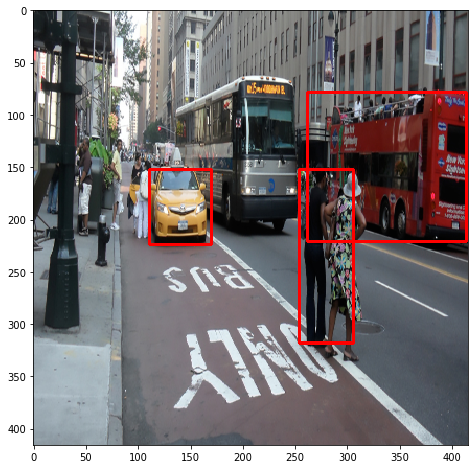

In [72]:
# 選一張圖像
#img_filepath = "./data/VOCdevkit/VOC2012/JPEGImages/2012_004315.jpg"
img_filepath = "./data/street.jpg"

# 使用OpenCV讀入圖像
images = cv2.imread(img_filepath) # 載入圖像
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)

# 進行圖像輸入的前處理
input_image = cv2.resize(images, (416, 416)) # 修改輸入圖像大小來符合模型的要求
input_image = input_image / 255. # 進行圖像歸一處理
input_image = np.expand_dims(input_image, 0)  # 增加 batch dimension

# 進行圖像偵測
yolo_outputs = yolo.predict(input_image)

image = cv2.resize(images, (416, 416))
scores, boxes, classes = yolo_eval(yolo_outputs, score_threshold=0.5)

# Draw bounding boxes on the image file
image = draw_boxes(image, scores, boxes, classes)

# Save
cv2.imwrite("./model_data/output.jpg", image)

plt.figure(figsize=(8, 8))
plt.imshow(image)